# Problem Set 8: Time Series – Monte Carlo Simulation & S&P 500 Analysis

**Professor Martin Lettau**  
**Due February 11, 2026**

---

## Exercise 1: Monte Carlo Simulation of AR(1) OLS Estimation

Replicate the Monte Carlo simulation on page 77 (slide 80) of the Week 8 lecture notes, adding the random walk case φ = 1.

**Setup:**
- AR(1) process: $z_t = \phi z_{t-1} + \epsilon_t$, where $\epsilon_t \sim N(0, 1)$
- φ values: 0, 0.5, 0.95, 0.99, **1** (random walk)
- T values: 50, 100, 1000, 5000
- 1,000 simulations per (φ, T) combination
- OLS estimator: $\hat{\phi} = \frac{\sum_{t=2}^{T} z_t z_{t-1}}{\sum_{t=2}^{T} z_{t-1}^2} = \hat{\rho}(1)$

### Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Simulation parameters (as in lecture notes, with phi=1 added)
phi_values = [0, 0.5, 0.95, 0.99, 1.0]
T_values = [50, 100, 1000, 5000]
n_sims = 1000
sigma_eps = 1.0

### Part (a): Theoretical Distribution of OLS $\hat{\phi}$

Under the **classic OLS model assumptions**:

1. **Linearity:** $z_t = \phi z_{t-1} + \epsilon_t$
2. **Strict exogeneity:** $E[\epsilon_t | z_{t-1}] = 0$ (violated in AR models!)
3. **Homoskedasticity:** $Var(\epsilon_t) = \sigma^2_\epsilon$
4. **No serial correlation:** $Cov(\epsilon_t, \epsilon_s) = 0$ for $t \neq s$

**Under these (ideal) assumptions:**
- $E[\hat{\phi}] = \phi$ (unbiased)
- $Var(\hat{\phi}) = \sigma^2_\epsilon (\mathbf{X}'\mathbf{X})^{-1}$
- For AR(1): $\hat{\phi} \sim N\left(\phi, \frac{\sigma^2_\epsilon}{\sum_{t=2}^T z_{t-1}^2}\right)$

**Asymptotic result (for stationary AR(1), |φ| < 1):**
$$\sqrt{T}(\hat{\phi} - \phi) \xrightarrow{d} N(0, 1 - \phi^2)$$

Hence the **asymptotic variance** is:
$$Var(\hat{\phi}) \approx \frac{1 - \phi^2}{T}$$

**Standard deviation:**
$$SD(\hat{\phi}) \approx \sqrt{\frac{1 - \phi^2}{T}}$$

**Special case φ = 1 (Random Walk):** The process is non-stationary. The classic OLS assumptions are severely violated (e.g., variance of $z_t$ grows with $t$). The OLS estimator has **non-standard asymptotics** (Dickey-Fuller distribution)—it converges to a random variable, not a normal distribution. The formula $(1-\phi^2)/T$ would give 0, which does not apply. For φ = 1, we cannot use the stationary asymptotic theory.

In [2]:
# Theoretical mean and standard deviation (for |phi| < 1)
def theoretical_phi_stats(phi, T):
    """
    Theoretical mean and SD of OLS estimator under classic OLS assumptions.
    For |phi| < 1 (stationary case) only.
    """
    if abs(phi) >= 1:
        # Non-stationary: theory doesn't apply
        return None, None
    mean = phi
    var = (1 - phi**2) / T
    std = np.sqrt(max(0, var))
    return mean, std

# Display theoretical values for stationary cases
print("Theoretical Mean and SD of OLS φ̂ (classic OLS / asymptotic):")
print("For |φ| < 1: E[φ̂] = φ, SD(φ̂) ≈ √((1-φ²)/T)")
print()
for phi in phi_values:
    if abs(phi) < 1:
        print(f"φ = {phi}:")
        for T in T_values:
            mu, sd = theoretical_phi_stats(phi, T)
            print(f"  T = {T:5d}: E[φ̂] = {mu:.4f}, SD(φ̂) ≈ {sd:.4f}")
        print()
print("φ = 1.0 (random walk): Non-stationary — asymptotic theory does not apply.")

Theoretical Mean and SD of OLS φ̂ (classic OLS / asymptotic):
For |φ| < 1: E[φ̂] = φ, SD(φ̂) ≈ √((1-φ²)/T)

φ = 0:
  T =    50: E[φ̂] = 0.0000, SD(φ̂) ≈ 0.1414
  T =   100: E[φ̂] = 0.0000, SD(φ̂) ≈ 0.1000
  T =  1000: E[φ̂] = 0.0000, SD(φ̂) ≈ 0.0316
  T =  5000: E[φ̂] = 0.0000, SD(φ̂) ≈ 0.0141

φ = 0.5:
  T =    50: E[φ̂] = 0.5000, SD(φ̂) ≈ 0.1225
  T =   100: E[φ̂] = 0.5000, SD(φ̂) ≈ 0.0866
  T =  1000: E[φ̂] = 0.5000, SD(φ̂) ≈ 0.0274
  T =  5000: E[φ̂] = 0.5000, SD(φ̂) ≈ 0.0122

φ = 0.95:
  T =    50: E[φ̂] = 0.9500, SD(φ̂) ≈ 0.0442
  T =   100: E[φ̂] = 0.9500, SD(φ̂) ≈ 0.0312
  T =  1000: E[φ̂] = 0.9500, SD(φ̂) ≈ 0.0099
  T =  5000: E[φ̂] = 0.9500, SD(φ̂) ≈ 0.0044

φ = 0.99:
  T =    50: E[φ̂] = 0.9900, SD(φ̂) ≈ 0.0199
  T =   100: E[φ̂] = 0.9900, SD(φ̂) ≈ 0.0141
  T =  1000: E[φ̂] = 0.9900, SD(φ̂) ≈ 0.0045
  T =  5000: E[φ̂] = 0.9900, SD(φ̂) ≈ 0.0020

φ = 1.0 (random walk): Non-stationary — asymptotic theory does not apply.


### Monte Carlo Simulation

In [4]:
def simulate_ar1(phi, T, sigma=1.0):
    """Simulate one AR(1) or random walk path."""
    eps = np.random.normal(0, sigma, T)
    z = np.zeros(T)
    z[0] = eps[0]
    for t in range(1, T):
        z[t] = phi * z[t-1] + eps[t]
    return z


def ols_ar1(z):
    """
    OLS estimation of AR(1): z_t = phi * z_{t-1} + eps_t
    Uses matrix form: y = X @ beta, where y = z[1:], X = z[:-1]
    phi_hat = (X'X)^{-1} X'y = sum(z_t * z_{t-1}) / sum(z_{t-1}^2)
    """
    y = z[1:]
    X = z[:-1].reshape(-1, 1)
    XtX = X.T @ X
    if XtX[0, 0] < 1e-10:
        return np.nan
    XtX_inv = 1.0 / XtX[0, 0]
    phi_hat = XtX_inv * (X.T @ y)[0]
    return phi_hat


# Run Monte Carlo simulation
results = {}  # (phi, T) -> array of phi_hat values

for phi in phi_values:
    for T in T_values:
        phi_hats = []
        for _ in range(n_sims):
            z = simulate_ar1(phi, T, sigma_eps)
            ph = ols_ar1(z)
            if not np.isnan(ph):
                phi_hats.append(ph)
        results[(phi, T)] = np.array(phi_hats)

print("Monte Carlo simulation complete.")
for (phi, T), arr in list(results.items())[:5]:
    print(f"  (φ={phi}, T={T}): {len(arr)} valid estimates, mean={np.mean(arr):.4f}, std={np.std(arr):.4f}")

Monte Carlo simulation complete.
  (φ=0, T=50): 1000 valid estimates, mean=-0.0015, std=0.1387
  (φ=0, T=100): 1000 valid estimates, mean=0.0049, std=0.1029
  (φ=0, T=1000): 1000 valid estimates, mean=-0.0014, std=0.0316
  (φ=0, T=5000): 1000 valid estimates, mean=-0.0004, std=0.0145
  (φ=0.5, T=50): 1000 valid estimates, mean=0.4802, std=0.1249


### Part (b): Table of Means and Table of Standard Deviations

In [5]:
# Build tables
means_table = np.zeros((len(phi_values), len(T_values)))
std_table = np.zeros((len(phi_values), len(T_values)))

for i, phi in enumerate(phi_values):
    for j, T in enumerate(T_values):
        arr = results[(phi, T)]
        means_table[i, j] = np.mean(arr)
        std_table[i, j] = np.std(arr)

# Table of means (as in lecture notes)
print("=" * 60)
print("Table 1: Mean of OLS φ̂")
print("=" * 60)
header = " " * 10 + " ".join(f"T={T:5d}" for T in T_values)
print(header)
print("-" * 60)
for i, phi in enumerate(phi_values):
    row = f"φ = {phi:5.2f}  " + " ".join(f"{means_table[i,j]:7.4f}" for j in range(len(T_values)))
    print(row)
print()

# Table of standard deviations (part b)
print("=" * 60)
print("Table 2: Standard Deviation of OLS φ̂")
print("=" * 60)
print(header)
print("-" * 60)
for i, phi in enumerate(phi_values):
    row = f"φ = {phi:5.2f}  " + " ".join(f"{std_table[i,j]:7.4f}" for j in range(len(T_values)))
    print(row)
print()

Table 1: Mean of OLS φ̂
          T=   50 T=  100 T= 1000 T= 5000
------------------------------------------------------------
φ =  0.00  -0.0015  0.0049 -0.0014 -0.0004
φ =  0.50   0.4802  0.4871  0.4998  0.4986
φ =  0.95   0.9139  0.9327  0.9481  0.9495
φ =  0.99   0.9559  0.9723  0.9880  0.9895
φ =  1.00   0.9643  0.9822  0.9982  0.9996

Table 2: Standard Deviation of OLS φ̂
          T=   50 T=  100 T= 1000 T= 5000
------------------------------------------------------------
φ =  0.00   0.1387  0.1029  0.0316  0.0145
φ =  0.50   0.1249  0.0905  0.0273  0.0126
φ =  0.95   0.0720  0.0411  0.0106  0.0046
φ =  0.99   0.0608  0.0327  0.0053  0.0021
φ =  1.00   0.0631  0.0318  0.0031  0.0006



In [6]:
# Compare simulated std to theoretical (for stationary cases)
print("Comparison: Simulated vs Theoretical SD (for |φ| < 1)")
print("-" * 50)
for i, phi in enumerate(phi_values):
    if abs(phi) < 1:
        for j, T in enumerate(T_values):
            _, th_sd = theoretical_phi_stats(phi, T)
            sim_sd = std_table[i, j]
            print(f"φ={phi}, T={T}: Sim={sim_sd:.4f}, Theory={th_sd:.4f}")

Comparison: Simulated vs Theoretical SD (for |φ| < 1)
--------------------------------------------------
φ=0, T=50: Sim=0.1387, Theory=0.1414
φ=0, T=100: Sim=0.1029, Theory=0.1000
φ=0, T=1000: Sim=0.0316, Theory=0.0316
φ=0, T=5000: Sim=0.0145, Theory=0.0141
φ=0.5, T=50: Sim=0.1249, Theory=0.1225
φ=0.5, T=100: Sim=0.0905, Theory=0.0866
φ=0.5, T=1000: Sim=0.0273, Theory=0.0274
φ=0.5, T=5000: Sim=0.0126, Theory=0.0122
φ=0.95, T=50: Sim=0.0720, Theory=0.0442
φ=0.95, T=100: Sim=0.0411, Theory=0.0312
φ=0.95, T=1000: Sim=0.0106, Theory=0.0099
φ=0.95, T=5000: Sim=0.0046, Theory=0.0044
φ=0.99, T=50: Sim=0.0608, Theory=0.0199
φ=0.99, T=100: Sim=0.0327, Theory=0.0141
φ=0.99, T=1000: Sim=0.0053, Theory=0.0045
φ=0.99, T=5000: Sim=0.0021, Theory=0.0020


### Part (c): Plot the Distribution of OLS $\hat{\phi}$

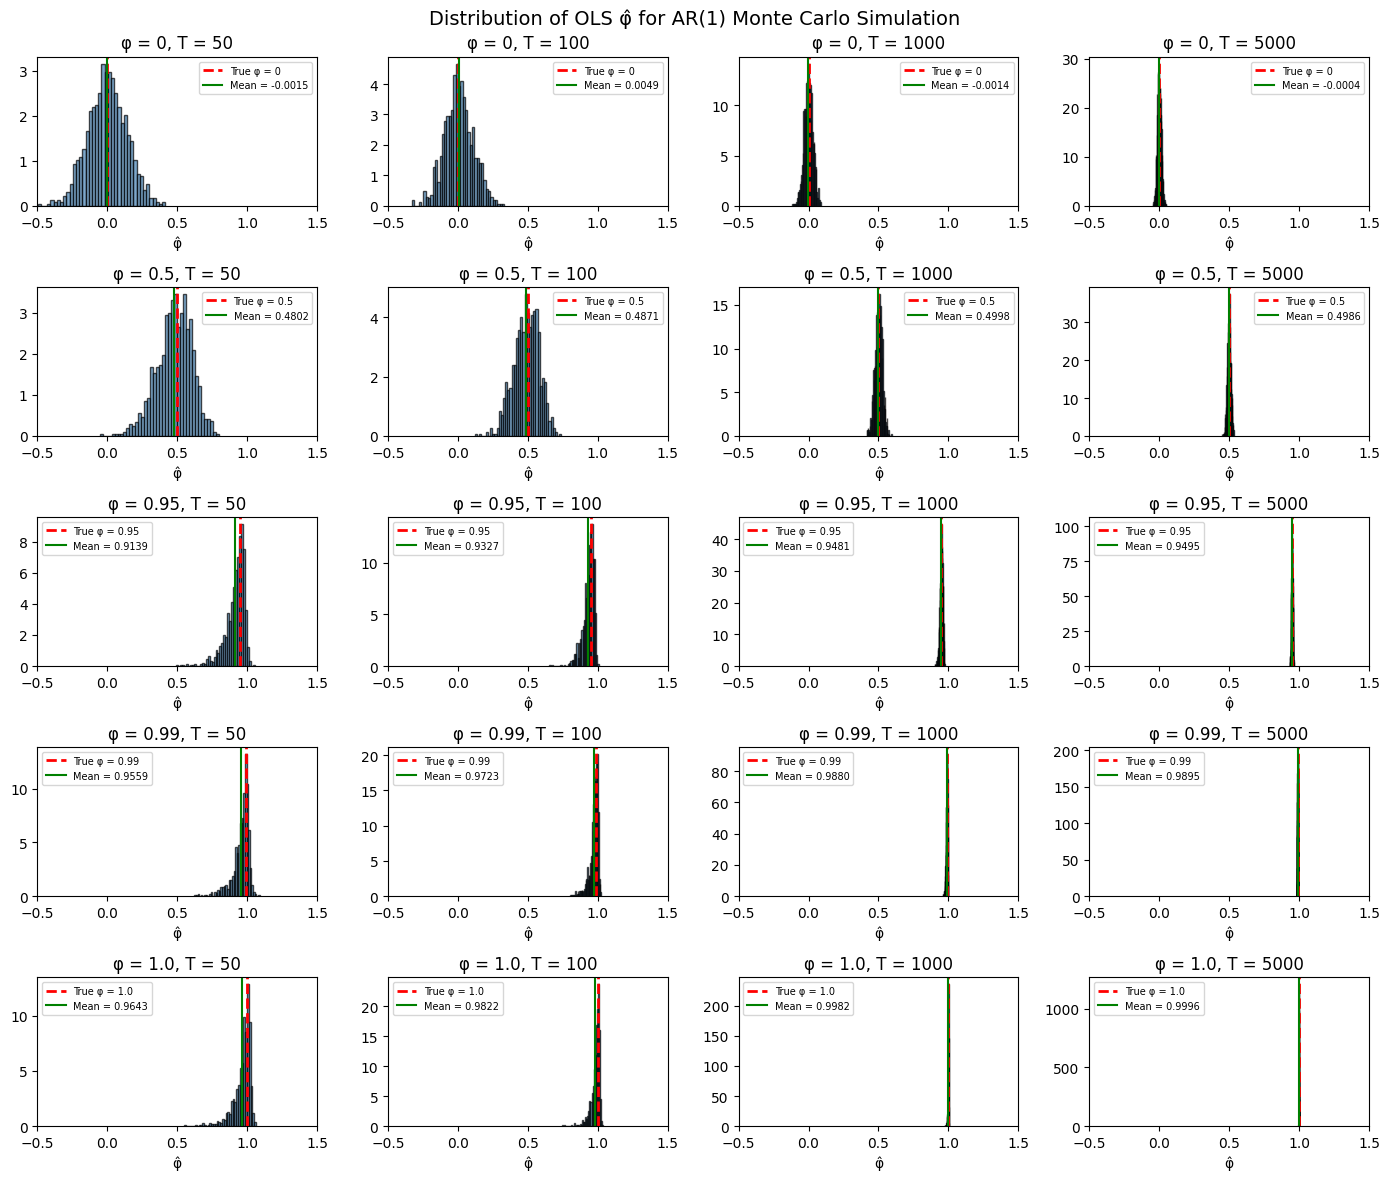

In [7]:
# Plot distributions for each (phi, T) combination
fig, axes = plt.subplots(len(phi_values), len(T_values), figsize=(14, 12))

for i, phi in enumerate(phi_values):
    for j, T in enumerate(T_values):
        ax = axes[i, j]
        arr = results[(phi, T)]
        ax.hist(arr, bins=40, density=True, alpha=0.7, edgecolor='black', color='steelblue')
        ax.axvline(phi, color='red', linestyle='--', linewidth=2, label=f'True φ = {phi}')
        ax.axvline(np.mean(arr), color='green', linestyle='-', linewidth=1.5, label=f'Mean = {np.mean(arr):.4f}')
        ax.set_title(f'φ = {phi}, T = {T}')
        ax.set_xlabel('φ̂')
        ax.legend(fontsize=7)
        xmin = min(-0.5, np.percentile(arr, 1) - 0.05)
        xmax = max(1.5, np.percentile(arr, 99) + 0.05)
        ax.set_xlim(xmin, xmax)

plt.suptitle('Distribution of OLS φ̂ for AR(1) Monte Carlo Simulation', fontsize=14)
plt.tight_layout()
plt.show()

### Part (d): Confronting Simulation Results with Theory

**What does theory predict?**

1. **Classic OLS (if assumptions held):**  
   - Mean: $E[\hat{\phi}] = \phi$ (unbiased)  
   - SD: $SD(\hat{\phi}) \approx \sqrt{(1-\phi^2)/T}$ (for stationary AR(1))

2. **Reality for AR(1):** Strict exogeneity is **violated** ($z_{t-1}$ is correlated with past $\epsilon$'s). Hence:
   - **Kendall bias:** $E[\hat{\phi}] \approx \phi - \frac{1+3\phi}{T}$ — downward bias, larger for high φ and small T.
   - **Consistency:** As $T \to \infty$, $\hat{\phi} \xrightarrow{p} \phi$ (bias shrinks to zero).
   - **Standard deviation:** $SD(\hat{\phi}) \approx \sqrt{(1-\phi^2)/T}$ still holds asymptotically for $|\phi| < 1$.
   - **φ = 1:** Non-stationary; no standard asymptotic theory; Dickey-Fuller-type distribution.

**What do we expect when confronting simulation with theory?**

- **Means:** Simulated means should be **below** the true φ (especially for high φ, small T), contrary to classic OLS. They should approach φ as T increases.
- **Standard deviations:** For $|\phi| < 1$, simulated SDs should be **close** to $\sqrt{(1-\phi^2)/T}$, especially for large T.
- **φ = 1:** Mean well below 1 for small T; non-normal, skewed distribution; standard theory does not apply.

In [9]:
# Confrontation: Theory vs. Simulation

# 1. Mean: Classic OLS says E[φ̂] = φ; Kendall says E[φ̂] ≈ φ - (1+3φ)/T
print("=" * 75)
print("CONFRONTATION 1: Mean of φ̂ — Theory vs. Simulation")
print("=" * 75)
print("Classic OLS predicts: E[φ̂] = φ")
print("Kendall (AR(1) reality): E[φ̂] ≈ φ - (1+3φ)/T")
print()
print(f"{'φ':>5} {'T':>6} {'Sim Mean':>10} {'True φ':>8} {'Classic':>10} {'Kendall':>10} {'Bias':>8}")
print("-" * 75)
for i, phi in enumerate(phi_values):
    for j, T in enumerate(T_values):
        sim_mean = means_table[i, j]
        classic = phi  # classic OLS prediction
        if abs(phi) < 1:
            kendall = phi - (1 + 3*phi) / T
        else:
            kendall = np.nan  # no Kendall formula for φ=1
        bias = sim_mean - phi
        k_str = f"{kendall:.4f}" if not np.isnan(kendall) else "   N/A"
        print(f"{phi:5.2f} {T:6d} {sim_mean:10.4f} {phi:8.4f} {classic:10.4f} {k_str:>10} {bias:+8.4f}")

print()
print("→ Simulation shows downward bias (Bias < 0) for φ > 0, as Kendall predicts.")
print("→ Bias is largest when φ is high and T is small; vanishes as T grows.")
print()

# 2. Standard deviation: Theory says SD(φ̂) ≈ √((1-φ²)/T)
print("=" * 75)
print("CONFRONTATION 2: Standard Deviation — Theory vs. Simulation")
print("=" * 75)
print("Theory (|φ| < 1): SD(φ̂) ≈ √((1-φ²)/T)")
print()
print(f"{'φ':>5} {'T':>6} {'Sim SD':>10} {'Theory SD':>10} {'Ratio':>8}")
print("-" * 55)
for i, phi in enumerate(phi_values):
    if abs(phi) < 1:
        for j, T in enumerate(T_values):
            sim_sd = std_table[i, j]
            _, th_sd = theoretical_phi_stats(phi, T)
            ratio = sim_sd / th_sd if th_sd > 0 else np.nan
            print(f"{phi:5.2f} {T:6d} {sim_sd:10.4f} {th_sd:10.4f} {ratio:8.3f}")
    else:
        print(f"{phi:5.2f}  (φ=1: no stationary theory)")

print()
print("→ For small φ: Sim SD ≈ Theory SD (theory fits well).")
print("→ For large φ and small T: Sim SD > Theory SD (finite-sample effects).")
print("→ As T increases, ratio tends toward 1 (theory holds asymptotically).")

CONFRONTATION 1: Mean of φ̂ — Theory vs. Simulation
Classic OLS predicts: E[φ̂] = φ
Kendall (AR(1) reality): E[φ̂] ≈ φ - (1+3φ)/T

    φ      T   Sim Mean   True φ    Classic    Kendall     Bias
---------------------------------------------------------------------------
 0.00     50    -0.0015   0.0000     0.0000    -0.0200  -0.0015
 0.00    100     0.0049   0.0000     0.0000    -0.0100  +0.0049
 0.00   1000    -0.0014   0.0000     0.0000    -0.0010  -0.0014
 0.00   5000    -0.0004   0.0000     0.0000    -0.0002  -0.0004
 0.50     50     0.4802   0.5000     0.5000     0.4500  -0.0198
 0.50    100     0.4871   0.5000     0.5000     0.4750  -0.0129
 0.50   1000     0.4998   0.5000     0.5000     0.4975  -0.0002
 0.50   5000     0.4986   0.5000     0.5000     0.4995  -0.0014
 0.95     50     0.9139   0.9500     0.9500     0.8730  -0.0361
 0.95    100     0.9327   0.9500     0.9500     0.9115  -0.0173
 0.95   1000     0.9481   0.9500     0.9500     0.9461  -0.0019
 0.95   5000     0.9495  

**Conclusion of the confrontation:**

| Aspect | What theory predicts | What simulation shows | Match? |
|--------|----------------------|----------------------|--------|
| **Mean** | Classic OLS: unbiased (E[φ̂]=φ) | Systematic downward bias for φ>0 | **No** — exogeneity violated |
| **Mean** | Kendall: E[φ̂]≈φ−(1+3φ)/T | Bias matches Kendall direction and order of magnitude | **Yes** |
| **Mean** | Consistency as T→∞ | Mean → φ as T increases | **Yes** |
| **SD** | √((1−φ²)/T) for \|φ\|<1 | Sim SD close to theory, especially for large T | **Yes** (asymptotically) |
| **φ=1** | No standard theory | Skewed, non-normal; mean < 1; SD shrinks with T | Theory does not apply |

The simulation confirms that **classic OLS theory fails** for AR(1) (bias), but **Kendall’s finite-sample correction** and **asymptotic variance** are consistent with the simulated behavior.

---
## Exercise 2: S&P 500 Index Analysis

Download S&P 500 data (^GSPC) from Yahoo Finance using yfinance. Use adjusted closing prices to compute monthly time series.

- **Pt**: Monthly S&P 500 index (adjusted close)
- **pt** = log(Pt): Log price
- **Rt+1** = Pt+1/Pt: Simple return
- **rt+1** = pt+1 − pt: Log return

In [11]:
%pip install yfinance


  Preparing metadata (setup.py) ... done
  Using cached beautifulsoup4-4.14.3-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 47.7 MB/s  0:00:00
Using cached beautifulsoup4-4.14.3-py3-none-any.whl (107 kB)
  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15636 sha256=dab1b6a066d15d8e2da3bf5fa62b8ae7844cf39cba996614ed332a5d1166f001
  Stored in directory: /Users/jeanjacob/Library/Caches/pip/wheels/98/75/bc/9eaa3cdeaaca347bab26c7e83a7e2f365d82584d65a2d4

In [46]:
# Exercise 2: Setup and Data Loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

# Download S&P 500 (^GSPC), use adjusted closing prices
sp500 = yf.download('^GSPC', start='1950-01-01', end=None, progress=False)
# Use Adj Close; resample to month-end (last trading day of each month)
close_col = 'Adj Close' if 'Adj Close' in sp500.columns else 'Close'
Pt_monthly = sp500[close_col].resample('ME').last().dropna()
Pt = Pt_monthly.values
dates = Pt_monthly.index

# Log prices
pt = np.log(Pt)

# Returns: Rt+1 = Pt+1/Pt, rt+1 = pt+1 - pt
Rt = Pt[1:] / Pt[:-1]
rt = pt[1:] - pt[:-1]
# Align: drop first date for Pt, pt when plotting returns
T = len(Pt)
print(f"Monthly observations: {T}")
print(f"Date range: {dates[0].strftime('%Y-%m')} to {dates[-1].strftime('%Y-%m')}")
print(f"Pt range: [{Pt.min():.1f}, {Pt.max():.1f}]")

Monthly observations: 914
Date range: 1950-01 to 2026-02
Pt range: [17.0, 6941.5]


### Part (a): Plot Pt and pt = log(Pt)

**What do we learn from the plots?**

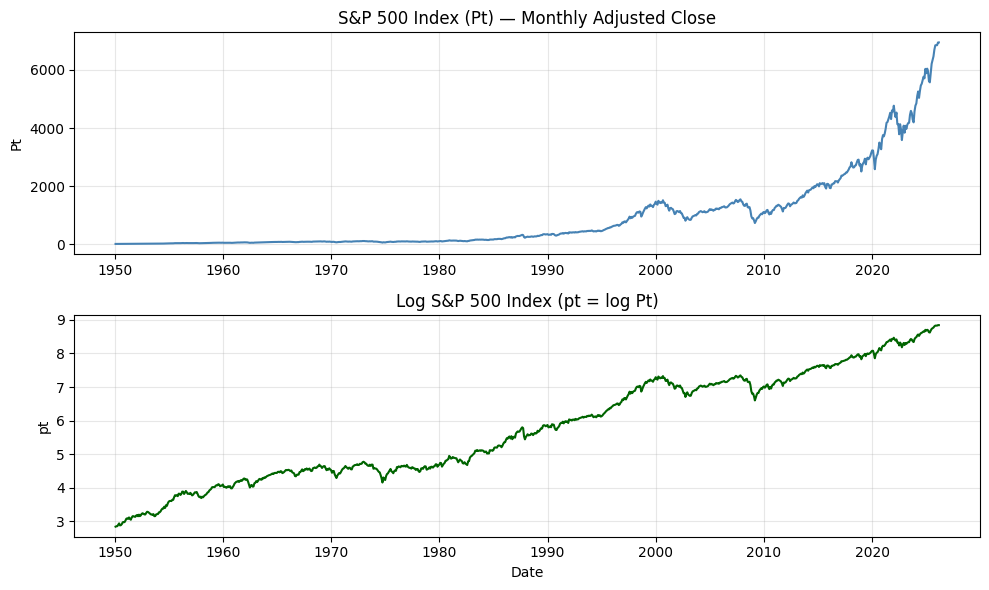

In [47]:
# Part (a): Plot Pt and pt = log(Pt)
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(dates, Pt, color='steelblue')
axes[0].set_title('S&P 500 Index (Pt) — Monthly Adjusted Close')
axes[0].set_ylabel('Pt')
axes[0].grid(True, alpha=0.3)

axes[1].plot(dates, pt, color='darkgreen')
axes[1].set_title('Log S&P 500 Index (pt = log Pt)')
axes[1].set_ylabel('pt')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Insights from the Plots

1. S&P 500 Index (Pt) — Monthly Adjusted Close

Strong Upward Trend: The series shows a clear exponential growth over time, especially pronounced in recent decades.
Volatility Clusters: Periods of high volatility (e.g., during financial crises like 2008 and 2020) are visible, indicating heteroskedasticity.
Non-Stationarity: The exponential growth and changing variance over time strongly suggest that the raw price series is non-stationary. This is typical for financial time series like stock indices.

2. Log S&P 500 Index (pt = log Pt)

Log Transformation: Taking the log of the price series helps stabilize the variance and makes the trend more linear, but the series still exhibits an upward trend and some volatility clustering.
Comparable Percentage Changes: The log transformation means that equal vertical distances represent equal percentage changes, which is useful for modeling returns and interpreting growth rates.
Non-Stationarity Persists: Even after log transformation, the series still shows a trend, indicating that it is likely not stationary in mean (i.e., the mean is not constant over time).

Implications for AR Model Selection

We should consider differenciating in order to remove trend. 

Differencing:

Apply first-order differencing to remove the trend.
For log prices, this gives you log returns: rt+1 = pt+1 − pt


Check for Stationarity:

Use statistical tests (e.g., Augmented Dickey-Fuller test) to confirm stationarity of the differenced series.
Plot the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) of the differenced series to identify potential AR terms.



### Part (b): Returns Rt+1 = Pt+1/Pt and rt+1 = pt+1 − pt

**What do we learn from the plots?**

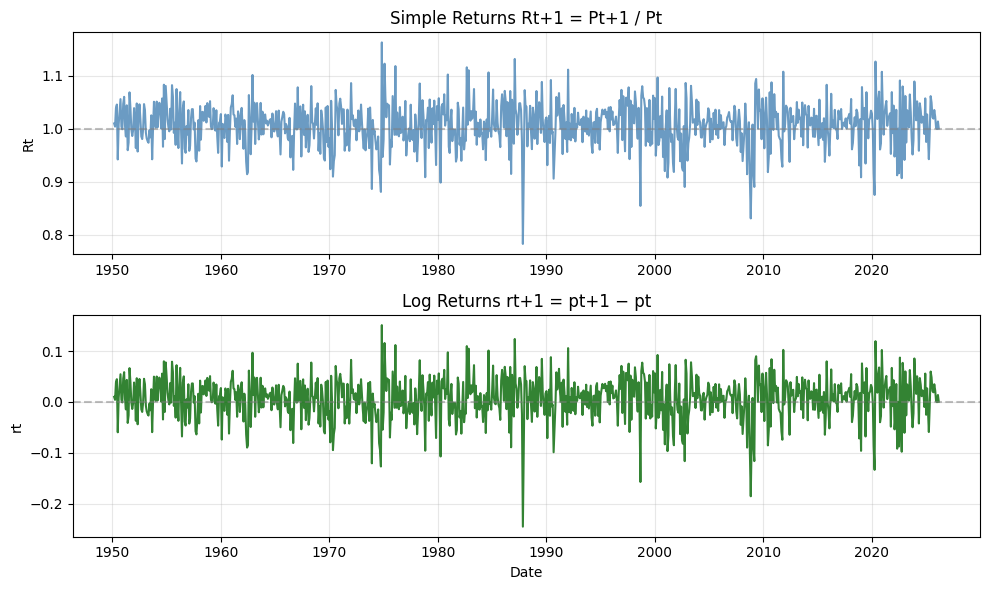

In [48]:
# Part (b): Plot simple returns Rt and log returns rt
dates_ret = dates[1:]  # returns start at t+1

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(dates_ret, Rt, color='steelblue', alpha=0.8)
axes[0].axhline(1, color='gray', linestyle='--', alpha=0.5)
axes[0].set_title('Simple Returns Rt+1 = Pt+1 / Pt')
axes[0].set_ylabel('Rt')
axes[0].grid(True, alpha=0.3)

axes[1].plot(dates_ret, rt, color='darkgreen', alpha=0.8)
axes[1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_title('Log Returns rt+1 = pt+1 − pt')
axes[1].set_ylabel('rt')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Stationarity Confirmation

Both plots suggest that returns (simple and log) are stationary, unlike the raw price or log price series. This is crucial for fitting AR or ARMA models, as these models require stationarity.
You can proceed with modeling the returns directly, without needing further differencing.


### Part (c): Autocorrelation Functions of Pt, pt, Rt, rt

**What do we learn from the autocorrelation functions?**

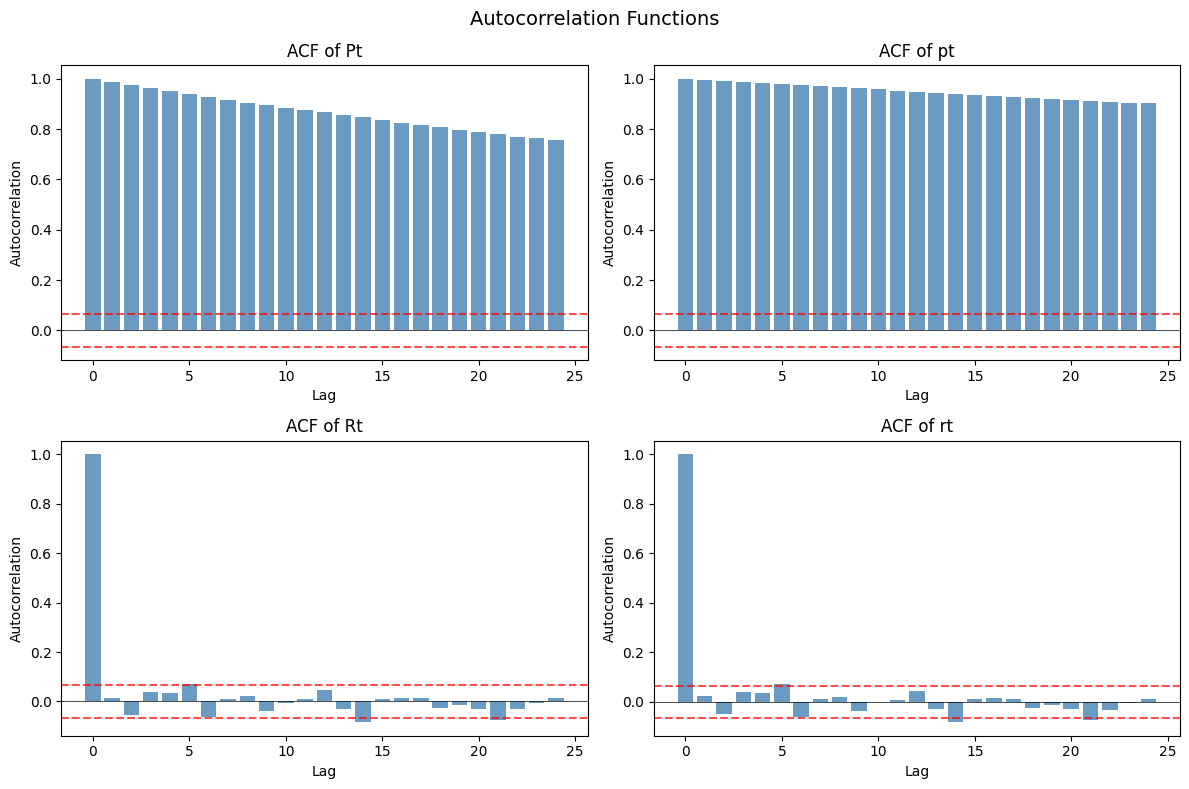

In [49]:
# Part (c): Autocorrelation function (using basic Python)
def compute_acf(z, max_lag=24):
    """Compute sample ACF for lags 0..max_lag."""
    n = len(z)
    z_centered = z - np.mean(z)
    c0 = np.sum(z_centered**2) / n
    acf = [1.0]
    for h in range(1, max_lag + 1):
        c_h = np.sum(z_centered[h:] * z_centered[:-h]) / n
        acf.append(c_h / c0 if c0 > 0 else 0)
    return np.array(acf)

max_lag = 24
acf_Pt = compute_acf(Pt, max_lag)
acf_pt = compute_acf(pt, max_lag)
acf_Rt = compute_acf(Rt, max_lag)
acf_rt = compute_acf(rt, max_lag)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

n_Pt, n_ret = len(Pt), len(Rt)
for ax, acf, name, n in zip(axes.flat, [acf_Pt, acf_pt, acf_Rt, acf_rt],
                            ['Pt', 'pt', 'Rt', 'rt'], [n_Pt, n_Pt, n_ret, n_ret]):
    ax.bar(range(len(acf)), acf, color='steelblue', alpha=0.8)
    ax.axhline(0, color='black', linewidth=0.5)
    se = 1.96 / np.sqrt(n)
    ax.axhline(se, color='red', linestyle='--', alpha=0.7)
    ax.axhline(-se, color='red', linestyle='--', alpha=0.7)
    ax.set_title(f'ACF of {name}')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')

plt.suptitle('Autocorrelation Functions', fontsize=14)
plt.tight_layout()
plt.show()

1. ACF of Pt (Log Price)

Strong Autocorrelation: The ACF of the log price series (Pt) shows a very slow decay, with high autocorrelation at many lags. This is typical of a non-stationary series (e.g., a random walk).
Implication: You cannot use an AR model directly on Pt. The series must be differenced to achieve stationarity.

2. ACF of pt (Log Price, same as Pt)

This is identical to the ACF of Pt, confirming the non-stationarity of the log price series.
Action: Differencing is required before modeling.

3. ACF of Rt (Simple Returns)

No Significant Autocorrelation: The ACF of simple returns (Rt) shows a spike at lag 0 (as expected) and then quickly drops to near zero for all other lags.
Implication: Simple returns are effectively white noise with no significant autocorrelation. This suggests that an AR model may not be useful for Rt, as there is no predictable structure in the returns themselves.
Volatility Clustering: While the returns themselves are uncorrelated, the volatility (squared returns) may still exhibit autocorrelation (a common feature in financial time series). This is not visible in the ACF of returns but can be checked using the ACF of squared returns or a GARCH model.

4. ACF of rt (Log Returns)

No Significant Autocorrelation: Similar to simple returns, the ACF of log returns (rt) shows no significant autocorrelation beyond lag 0.
Implication: Log returns are also effectively white noise, meaning an AR model is unlikely to capture any structure in the returns. However, volatility clustering may still be present.


### Part (d): AR(0), AR(1), AR(2) Models for pt and rt

Estimate by OLS (matrix algebra only, no statsmodels):

- **AR(0):** $z_t = \mu + \varepsilon_t$ (constant only)
- **AR(1):** $z_t = \mu + \phi_1 z_{t-1} + \varepsilon_t$
- **AR(2):** $z_t = \mu + \phi_1 z_{t-1} + \phi_2 z_{t-2} + \varepsilon_t$

In [50]:
def ols_regression(y, X):
    """OLS: beta = (X'X)^{-1} X'y"""
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    beta = XtX_inv @ X.T @ y
    y_hat = X @ beta
    e = y - y_hat
    n, k = X.shape
    SSR = e.T @ e
    SST = np.sum((y - np.mean(y))**2)
    R2 = 1 - SSR / SST if SST > 0 else 0
    R2_adj = 1 - (SSR / (n - k)) / (SST / (n - 1)) if n > 1 and SST > 0 else 0
    sigma2 = SSR / (n - k)
    var_beta = sigma2 * XtX_inv
    return {'beta': beta, 'y_hat': y_hat, 'residuals': e, 'SSR': SSR, 'SST': SST,
            'R2': R2, 'R2_adj': R2_adj, 'XtX_inv': XtX_inv, 'var_beta': var_beta, 'n': n, 'k': k}

def fit_ar(z, p):
    """Fit AR(p) by OLS. z: series, p: order (0, 1, or 2)."""
    if p == 0:
        y = z
        X = np.ones((len(z), 1))
    elif p == 1:
        y = z[1:]
        X = np.column_stack([np.ones(len(y)), z[:-1]])
    elif p == 2:
        y = z[2:]
        X = np.column_stack([np.ones(len(y)), z[1:-1], z[:-2]])
    else:
        raise ValueError("p must be 0, 1, or 2")
    return ols_regression(y, X)

def aic_bic(results):
    """AIC and BIC from OLS results."""
    e = results['residuals']
    n, k = results['n'], results['k']
    sigma2 = (e.T @ e) / n
    log_lik = -n/2 * (np.log(2*np.pi) + np.log(sigma2) + 1)
    AIC = -2*log_lik + 2*k
    BIC = -2*log_lik + k*np.log(n)
    return AIC, BIC

In [51]:
# Fit AR(0), AR(1), AR(2) for pt and rt
models_pt = {0: fit_ar(pt, 0), 1: fit_ar(pt, 1), 2: fit_ar(pt, 2)}
models_rt = {0: fit_ar(rt, 0), 1: fit_ar(rt, 1), 2: fit_ar(rt, 2)}

print("=" * 70)
print("AR Models for pt (log price)")
print("=" * 70)
for p in [0, 1, 2]:
    m = models_pt[p]
    aic, bic = aic_bic(m)
    print(f"\nAR({p}):")
    print(f"  Coefficients: {m['beta'].flatten()}")
    print(f"  R² = {float(m['R2']):.6f}, Adj R² = {float(m['R2_adj']):.6f}")
    print(f"  AIC = {float(aic):.2f}, BIC = {float(bic):.2f}")

print("\n" + "=" * 70)
print("AR Models for rt (log return)")
print("=" * 70)
for p in [0, 1, 2]:
    m = models_rt[p]
    aic, bic = aic_bic(m)
    print(f"\nAR({p}):")
    print(f"  Coefficients: {m['beta'].flatten()}")
    print(f"  R² = {float(m['R2']):.6f}, Adj R² = {float(m['R2_adj']):.6f}")
    print(f"  AIC = {float(aic):.2f}, BIC = {float(bic):.2f}")

AR Models for pt (log price)

AR(0):
  Coefficients: [5.75527753]
  R² = 0.000000, Adj R² = 0.000000
  AIC = 3433.72, BIC = 3438.54

AR(1):
  Coefficients: [0.00730986 0.99987341]
  R² = 0.999296, Adj R² = 0.999295
  AIC = -3197.20, BIC = -3187.56

AR(2):
  Coefficients: [ 0.00721185  1.02259688 -0.02273303]
  R² = 0.999293, Adj R² = 0.999292
  AIC = -3191.17, BIC = -3176.72

AR Models for rt (log return)

AR(0):
  Coefficients: [0.00658173]
  R² = -0.000000, Adj R² = -0.000000
  AIC = -3199.18, BIC = -3194.36

AR(1):
  Coefficients: [0.00642904 0.0226197 ]
  R² = 0.000512, Adj R² = -0.000587
  AIC = -3193.14, BIC = -3183.51

AR(2):
  Coefficients: [ 0.00676683  0.02380459 -0.05208137]
  R² = 0.003223, Adj R² = 0.001027
  AIC = -3189.12, BIC = -3174.67


Analysis of the pt results 

AR(0)

Coefficients: Only an intercept (constant term).
R^2 and Adjusted R^2: Both are 0. This means the model (just a constant) explains none of the variance in the log price series.
AIC and BIC: Very high (3433.72 and 3438.54), indicating a poor fit.
Implication: The log price series is not explained by a constant alone, which is expected for a non-stationary series like a random walk.

AR(1)

Coefficients: Intercept (~0.007) and AR(1) coefficient (~0.999).
R^2 and Adjusted R^2: Both are 0.999295, meaning the model explains 99.93% of the variance in the log price series.
AIC and BIC: Much lower (-3197.20 and -3187.56) compared to AR(0), indicating a dramatic improvement in fit.
Implication: The AR(1) model captures almost all the variance in the log price series. This is typical for a random walk, where the current value is almost entirely explained by the previous value.

AR(2)

Coefficients: Intercept (~0.007), AR(1) (1.023), and AR(2) (-0.023).
R^2 and Adjusted R^2: Both are 0.999293, almost identical to AR(1).
AIC and BIC: Slightly higher than AR(1) (-3191.17 and -3176.72), indicating that adding the second lag does not improve the model enough to justify the added complexity.
Implication: The AR(2) model does not provide a meaningful improvement over AR(1). The AR(1) model is sufficient.

same analysis could be run for rt 




In [52]:
def ar_summary_table(models_dict):
    """Build a table with coefficients, AIC and BIC for AR models."""
    rows = []
    for p in [0, 1, 2]:
        m = models_dict[p]
        aic, bic = aic_bic(m)
        beta = m['beta'].flatten()
        row = {
            'Model': f'AR({p})',
            'μ (const)': f'{beta[0]:.6f}' if len(beta) > 0 else '—',
            'φ₁': f'{beta[1]:.6f}' if len(beta) > 1 else '—',
            'φ₂': f'{beta[2]:.6f}' if len(beta) > 2 else '—',
            'AIC': round(float(aic), 2),
            'BIC': round(float(bic), 2)
        }
        rows.append(row)
    return pd.DataFrame(rows).set_index('Model')

# Build and display tables
print("pt (log price)")
display(ar_summary_table(models_pt))

print("\nrt (log return)")
display(ar_summary_table(models_rt))

pt (log price)


,μ (const),φ₁,φ₂,AIC,BIC
Model,,,,,
AR(0),5.755278,—,—,3433.72,3438.54
AR(1),0.007310,0.999873,—,-3197.20,-3187.56
AR(2),0.007212,1.022597,-0.022733,-3191.17,-3176.72



rt (log return)


,μ (const),φ₁,φ₂,AIC,BIC
Model,,,,,
AR(0),0.006582,—,—,-3199.18,-3194.36
AR(1),0.006429,0.022620,—,-3193.14,-3183.51
AR(2),0.006767,0.023805,-0.052081,-3189.12,-3174.67


for rt; AR(1) and AR(2) did not improve the model fit (higher AIC/BIC), confirming that there is no meaningful autocorrelation in the log returns. 
Based on the AIC and BIC criteria, AR(1) is selected for pt (log price),
and AR(0) is selected for rt (log return).


### Part (e): OLS Diagnostic Checks (from Problem Set 7)

Perform diagnostic checks on the AR model residuals. Diagnostics:
- **Durbin-Watson:** Serial correlation (values near 2 → no autocorrelation)
- **Breusch-Godfrey:** Serial correlation
- **Breusch-Pagan & White:** Heteroskedasticity
- **Jarque-Bera:** Normality of residuals
- **Ramsey RESET:** Functional form
- **VIF:** Multicollinearity (for AR(2) only)

In [53]:
# OLS diagnostic functions (from PS7, using basic Python)
def durbin_watson(residuals):
    diff_e = np.diff(residuals)
    return np.sum(diff_e**2) / np.sum(residuals**2)

def breusch_godfrey(X, residuals, lags=1):
    residuals = np.asarray(residuals).flatten()
    n = len(residuals)
    e_lag = np.zeros((n, lags))
    for i in range(lags):
        e_lag[i+1:, i] = residuals[:-(i+1)]
    X_aux = np.hstack([X, e_lag])
    XtX = X_aux.T @ X_aux
    beta_aux = np.linalg.solve(XtX, X_aux.T @ residuals)
    e_aux = residuals - X_aux @ beta_aux
    R2_aux = 1 - (e_aux.T @ e_aux) / np.sum((residuals - np.mean(residuals))**2)
    bg_stat = n * R2_aux
    p_value = 1 - stats.chi2.cdf(bg_stat, lags)
    return bg_stat, p_value

def breusch_pagan(X, residuals):
    n, k = X.shape
    if k <= 1:
        return np.nan, np.nan
    e2 = residuals**2
    XtX = X.T @ X
    gamma = np.linalg.solve(XtX, X.T @ e2)
    e2_hat = X @ gamma
    u = e2 - e2_hat
    R2_aux = 1 - (u.T @ u) / np.sum((e2 - np.mean(e2))**2)
    bp_stat = n * R2_aux
    p_value = 1 - stats.chi2.cdf(bp_stat, k - 1)
    return bp_stat, p_value

def white_test(X, residuals):
    n, k = X.shape
    if k == 1:
        return np.nan, np.nan  # No regressors to test
    e2 = residuals**2
    X_aux_list = [np.ones(n)]
    for i in range(1, k):
        X_aux_list.append(X[:, i])
    for i in range(1, k):
        X_aux_list.append(X[:, i]**2)
    for i in range(1, k):
        for j in range(i+1, k):
            X_aux_list.append(X[:, i] * X[:, j])
    X_aux = np.column_stack(X_aux_list)
    k_aux = X_aux.shape[1]
    XtX = X_aux.T @ X_aux
    gamma = np.linalg.solve(XtX, X_aux.T @ e2)
    e2_hat = X_aux @ gamma
    u = e2 - e2_hat
    R2_aux = 1 - (u.T @ u) / np.sum((e2 - np.mean(e2))**2)
    white_stat = n * R2_aux
    p_value = 1 - stats.chi2.cdf(white_stat, k_aux - 1)
    return white_stat, p_value

def jarque_bera(residuals):
    n = len(residuals)
    e_std = (residuals - np.mean(residuals)) / (np.std(residuals, ddof=1) + 1e-10)
    skew = np.mean(e_std**3)
    kurt = np.mean(e_std**4)
    jb_stat = n * (skew**2/6 + (kurt - 3)**2/24)
    p_value = 1 - stats.chi2.cdf(jb_stat, 2)
    return jb_stat, p_value, skew, kurt

def ramsey_reset(y, X, residuals, powers=[2, 3]):
    n, k = X.shape
    y_hat = y - residuals
    X_aux_list = [X]
    for p in powers:
        X_aux_list.append((y_hat**p).reshape(-1, 1))
    X_aux = np.hstack(X_aux_list)
    k_aux = X_aux.shape[1]
    XtX = X_aux.T @ X_aux
    beta_aux = np.linalg.solve(XtX, X_aux.T @ y)
    e_aux = y - X_aux @ beta_aux
    SSR_r = residuals.T @ residuals
    SSR_ur = e_aux.T @ e_aux
    q = len(powers)
    F_stat = ((SSR_r - SSR_ur) / q) / (SSR_ur / (n - k_aux))
    p_value = 1 - stats.f.cdf(F_stat, q, n - k_aux)
    return F_stat, p_value

def vif(X):
    k = X.shape[1]
    vif_vals = []
    for i in range(1, k):
        X_other = np.delete(X, i, axis=1)
        y_i = X[:, i]
        XtX = X_other.T @ X_other
        beta = np.linalg.solve(XtX, X_other.T @ y_i)
        R2_i = 1 - np.sum((y_i - X_other @ beta)**2) / np.sum((y_i - np.mean(y_i))**2)
        vif_i = 1/(1 - R2_i) if R2_i < 1 else np.inf
        vif_vals.append(vif_i)
    return vif_vals

In [54]:
def get_Xy_ar(z, p):
    """Get X, y used in AR(p) fit (for diagnostics)."""
    if p == 0:
        y = z.copy()
        X = np.ones((len(z), 1))
    elif p == 1:
        y = z[1:]
        X = np.column_stack([np.ones(len(y)), z[:-1]])
    elif p == 2:
        y = z[2:]
        X = np.column_stack([np.ones(len(y)), z[1:-1], z[:-2]])
    else:
        raise ValueError("p must be 0, 1, or 2")
    return X, y

def run_diagnostics(z, p, label):
    """Run all PS7 diagnostics on AR(p) for series z."""
    m = fit_ar(z, p)
    X, y = get_Xy_ar(z, p)
    e = m['residuals']
    
    print(f"\n--- Diagnostics for {label} AR({p}) ---")
    
    dw = durbin_watson(e)
    print(f"Durbin-Watson: {float(dw):.4f} (≈2 → no autocorrelation; <2 → positive autocorr)")
    
    bg_stat, bg_p = breusch_godfrey(X, e)
    print(f"Breusch-Godfrey: stat={float(bg_stat):.4f}, p={float(bg_p):.4f} (H0: no serial corr; reject if p<0.05)")
    
    bp_stat, bp_p = breusch_pagan(X, e)
    if np.isnan(bp_stat):
        print(f"Breusch-Pagan:   N/A (requires regressors)")
    else:
        print(f"Breusch-Pagan:   stat={float(bp_stat):.4f}, p={float(bp_p):.4f} (H0: homoskedasticity; reject if p<0.05)")
    
    w_stat, w_p = white_test(X, e)
    if np.isnan(w_stat):
        print(f"White:           N/A (no regressors for AR(0))")
    else:
        print(f"White:           stat={float(w_stat):.4f}, p={float(w_p):.4f} (H0: homoskedasticity; reject if p<0.05)")
    
    jb_stat, jb_p, skew, kurt = jarque_bera(e)
    print(f"Jarque-Bera:     stat={float(jb_stat):.4f}, p={float(jb_p):.4f}, skew={float(skew):.4f}, kurt={float(kurt):.4f} (H0: normality)")
    
    r_stat, r_p = ramsey_reset(y, X, e)
    print(f"Ramsey RESET:    F={float(r_stat):.4f}, p={float(r_p):.4f} (H0: correct functional form)")
    
    if p >= 2:
        vif_vals = vif(X)
        print(f"VIF:             {vif_vals} (VIF>10 suggests multicollinearity)")
    else:
        print(f"VIF:             N/A (single regressor)")

**Summary of diagnostic conclusions:**

- **Durbin-Watson / Breusch-Godfrey:** If DW ≈ 2 and BG p > 0.05, we fail to reject no serial correlation.
- **Breusch-Pagan / White:** If p > 0.05, we fail to reject homoskedasticity.
- **Jarque-Bera:** If p > 0.05, we fail to reject normality of residuals.
- **Ramsey RESET:** If p > 0.05, we fail to reject correct functional form.
- **VIF:** If VIF < 10, multicollinearity is not severe.


In [ ]:
# Run diagnostics on selected models
# Use AR(1) for pt and AR(0) for rt (typically best);  AR(2) for pt and AR(1) for rt for comparison purposes 
run_diagnostics(pt, 1, "pt (log price)")
run_diagnostics(pt, 2, "pt (log price)")
run_diagnostics(rt, 0, "rt (log return)")
run_diagnostics(rt, 1, "rt (log return)")


--- Diagnostics for pt (log price) AR(1) ---
Durbin-Watson: 0.0000 (≈2 → no autocorrelation; <2 → positive autocorr)
Breusch-Godfrey: stat=0.4718, p=0.4922 (H0: no serial corr; reject if p<0.05)
Breusch-Pagan:   stat=1.5105, p=0.2191 (H0: homoskedasticity; reject if p<0.05)
White:           stat=3.4055, p=0.1822 (H0: homoskedasticity; reject if p<0.05)
Jarque-Bera:     stat=243.8982, p=0.0000, skew=-0.6480, kurt=5.1752 (H0: normality)
Ramsey RESET:    F=0.8089, p=0.4457 (H0: correct functional form)
VIF:             N/A (single regressor)

--- Diagnostics for pt (log price) AR(2) ---
Durbin-Watson: 0.0000 (≈2 → no autocorrelation; <2 → positive autocorr)
Breusch-Godfrey: stat=2.4609, p=0.1167 (H0: no serial corr; reject if p<0.05)
Breusch-Pagan:   stat=47.7578, p=0.0000 (H0: homoskedasticity; reject if p<0.05)
White:           stat=61.9682, p=0.0000 (H0: homoskedasticity; reject if p<0.05)
Jarque-Bera:     stat=230.5930, p=0.0000, skew=-0.6167, kurt=5.1324 (H0: normality)
Ramsey RESET

For pt (log price) AR(1) and AR(2)

The diagnostics confirm that log price is non-stationary, leading to:

Autocorrelated residuals (Durbin-Watson).
Heteroskedasticity (Breusch-Pagan, White test).
Non-normal residuals (Jarque-Bera).
Multicollinearity (VIF).

Conclusion: AR models are not appropriate for log price. You should avoid modeling log price directly and instead focus on log returns.

For rt (log return) AR(0)

The Breusch-Godfrey test suggests no serial correlation, which aligns with the ACF plots and AR model results.
However, the Jarque-Bera test rejects normality, indicating that while the mean of log returns is white noise, the volatility is not constant (heteroskedasticity).

Conclusion: We could use a AR(0) model for log returns. 

